In [45]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('../data/processed/processed_data.csv')

X, y = df.iloc[:, list(range(0, 10)) + list(range(38, 49))], df.iloc[:, 49:]
# X, y = df.iloc[:, :49], df.iloc[:, 49:]

# split the multi-labels into train and test
y_train = y.iloc[:int(len(y) * 0.8), :]
y_test = y.iloc[int(len(y) * 0.8):, :]
X_train = X.iloc[:int(len(X) * 0.8), :]
X_test = X.iloc[int(len(X) * 0.8):, :]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(114890, 21) (114890, 7) (28723, 21) (28723, 7)


In [46]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
print(f'Train score: {rf.score(X_test, y_test)}')

# print f1 score
from sklearn.metrics import f1_score
print(f'Test score: {f1_score(y_test, rf.predict(X_test), average="micro")}')

Train score: 0.5664450092260558
Test score: 0.7490751271291686


<AxesSubplot: >

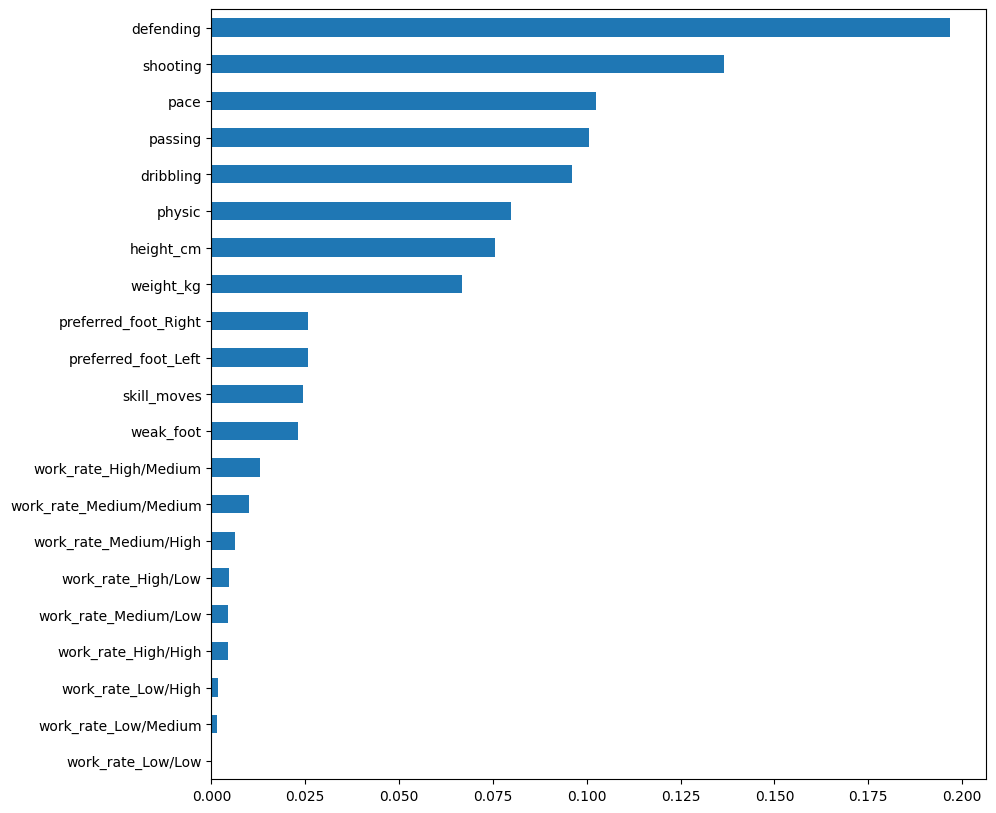

In [47]:
# draw feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot.barh(ax=ax)

In [48]:
X_test.head()
y_test.head()

# 110 columns in the dataset
# 160k+ rows
pd.set_option('display.max_columns', 110)
pd.set_option('display.max_rows', 1000)

y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)


In [49]:

# display the first 100 rows highlighting the 1s
y_pred.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')


,ST,LW,RW,CM,RB,LB,CB
0,0,1,1,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0
6,0,1,0,0,0,0,0
7,0,0,0,0,0,0,1
8,0,0,0,0,1,0,0
9,0,0,0,0,0,1,0


In [50]:
# display the first 100 rows highlighting the 1s
y_test.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')


,ST,LW,RW,CM,RB,LB,CB
114890,1,1,0,0,0,0,0
114891,0,0,0,1,0,0,0
114892,0,0,0,1,0,0,0
114893,0,0,0,0,0,0,1
114894,0,1,0,1,0,0,0
114895,0,0,0,1,0,0,0
114896,1,1,1,0,0,0,0
114897,0,0,0,1,0,0,0
114898,0,0,0,1,0,0,0
114899,0,0,0,0,0,1,0


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               2816      
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 7)                 455       
                                                                 
Total params: 11,527
Trainable params: 11,527
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/home/ahmed/anaconda3/envs/cmps460/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


460/460 [==============================] - 1s 1ms/step - loss: 0.3604 - accuracy: 0.5066 - val_loss: 0.2740 - val_accuracy: 0.6237
Epoch 2/100
460/460 [==============================] - 1s 1ms/step - loss: 0.2789 - accuracy: 0.6176 - val_loss: 0.2545 - val_accuracy: 0.6383
Epoch 3/100
460/460 [==============================] - 1s 1ms/step - loss: 0.2673 - accuracy: 0.6316 - val_loss: 0.2485 - val_accuracy: 0.6586
Epoch 4/100
460/460 [==============================] - 1s 1ms/step - loss: 0.2618 - accuracy: 0.6387 - val_loss: 0.2439 - val_accuracy: 0.6674
Epoch 5/100
460/460 [==============================] - 1s 1ms/step - loss: 0.2584 - accuracy: 0.6416 - val_loss: 0.2414 - val_accuracy: 0.6723
Epoch 6/100
460/460 [==============================] - 1s 1ms/step - loss: 0.2565 - accuracy: 0.6443 - val_loss: 0.2398 - val_accuracy: 0.6779
Epoch 7/100
460/460 [==============================] - 1s 1ms/step - loss: 0.2549 - accuracy: 0.6461 - val_loss: 0.2383 - val_accuracy: 0.6607
Epoch 8/100

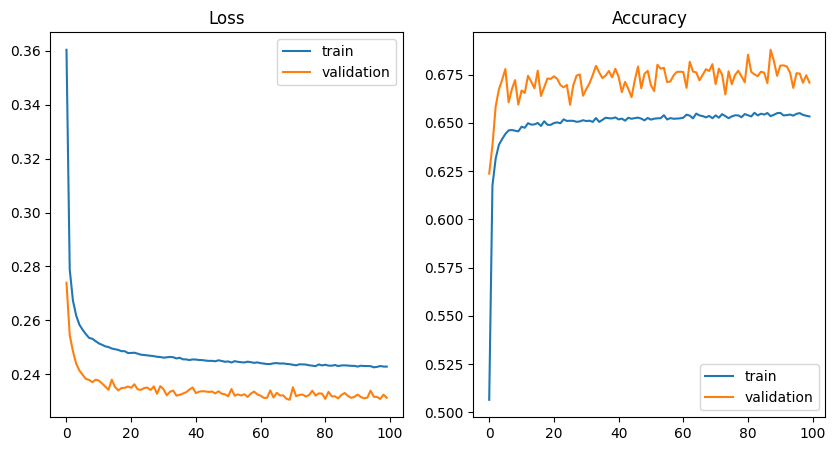

In [62]:
# use ANN to predict the multi-labels
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), metrics=['accuracy'], loss='binary_crossentropy')
model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.2)

# plot the loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='validation')
ax[1].set_title('Accuracy')
ax[1].legend()


In [63]:
# evaluate the model
model.evaluate(X_test, y_test)

# predict the test set
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)

# display the first 100 rows highlighting the 1s
y_pred.head(10).style.applymap(lambda x: 'background-color : yellow' if x > 0.5 else '')


898/898 [==============================] - 0s 367us/step


,ST,LW,RW,CM,RB,LB,CB
0,0.636555,0.498408,0.502586,0.297661,0.002475,0.000557,0.000009
1,0.000824,0.000372,0.002064,0.680926,0.073942,0.010750,0.629667
2,0.000145,0.003800,0.020700,0.800148,0.229736,0.052604,0.366366
3,0.000149,0.000151,0.000878,0.061814,0.163186,0.029765,0.987850
4,0.001992,0.398763,0.015696,0.089353,0.013655,0.967224,0.021090
5,0.060536,0.318278,0.470737,0.823670,0.075867,0.010988,0.001200
6,0.072215,0.781802,0.578559,0.392021,0.002471,0.047402,0.000042
7,0.000071,0.000262,0.001206,0.090039,0.225478,0.042997,0.977631
8,0.008509,0.073042,0.454749,0.155856,0.878922,0.180631,0.020001
9,0.002886,0.554013,0.036056,0.071110,0.049519,0.966564,0.028403


In [53]:
# display the first 100 rows highlighting the 1s
y_test.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')

,ST,LW,RW,CM,RB,LB,CB
114890,1,1,0,0,0,0,0
114891,0,0,0,1,0,0,0
114892,0,0,0,1,0,0,0
114893,0,0,0,0,0,0,1
114894,0,1,0,1,0,0,0
114895,0,0,0,1,0,0,0
114896,1,1,1,0,0,0,0
114897,0,0,0,1,0,0,0
114898,0,0,0,1,0,0,0
114899,0,0,0,0,0,1,0


In [54]:
# display y train
X_train.head(10).style.applymap(lambda x: 'background-color : yellow' if x == 1 else '')

,height_cm,weight_kg,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,preferred_foot_Left,preferred_foot_Right
0,0.288462,0.295082,0.500000,0.750000,0.947368,0.937500,0.904110,1.000000,0.168831,0.553846,0,0,0,0,0,0,0,1,0,1,0
1,0.596154,0.508197,0.750000,1.000000,0.947368,0.987500,0.835616,0.932432,0.233766,0.800000,0,1,0,0,0,0,0,0,0,0,1
2,0.500000,0.508197,0.250000,0.750000,0.947368,0.900000,0.863014,0.945946,0.233766,0.569231,0,1,0,0,0,0,0,0,0,1,0
3,0.788462,0.754098,0.750000,0.750000,0.723684,0.962500,0.835616,0.864865,0.259740,0.907692,0,0,0,0,0,0,0,1,0,0,1
4,0.307692,0.262295,0.750000,0.750000,0.710526,0.725000,0.945205,0.932432,0.584416,0.553846,0,0,1,0,0,0,0,0,0,0,1
5,0.519231,0.524590,0.750000,0.750000,0.815789,0.912500,0.808219,0.891892,0.363636,0.800000,0,0,1,0,0,0,0,0,0,0,1
6,0.634615,0.360656,0.500000,0.750000,0.697368,0.950000,0.849315,0.824324,0.246753,0.630769,0,0,0,0,0,0,0,1,0,1,0
7,0.557692,0.491803,0.500000,0.500000,0.526316,0.837500,0.890411,0.810811,0.831169,0.815385,1,0,0,0,0,0,0,0,0,0,1
8,0.307692,0.377049,0.750000,1.000000,0.894737,0.800000,0.890411,0.945946,0.194805,0.538462,0,0,1,0,0,0,0,0,0,0,1
9,0.442308,0.377049,0.750000,0.750000,0.736842,0.900000,0.602740,0.797297,0.337662,0.707692,0,0,1,0,0,0,0,0,0,0,1
